In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as tvf
import torchvision.models as tvm
import matplotlib.pyplot as plt
import datasets as hfds

from mus import *
from quickshift import *

/home/antonxue/lib/miniconda3/envs/tfl/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
imagenette = hfds.load_dataset("frgfm/imagenette", "160px", split="train", trust_remote_code=True)

In [3]:
def pil_to_pt(pil_img):
    tf = tvf.Compose([
        tvf.ToTensor(),
        tvf.Resize((256,256))
    ])
    return tf(pil_img)

In [4]:
batch = torch.stack([pil_to_pt(imagenette[i]["image"]) for i in range(7)])

/home/antonxue/lib/miniconda3/envs/tfl/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [5]:
batch.shape

torch.Size([7, 3, 256, 256])

In [6]:
resnet = tvm.resnet50(pretrained=True)
resnet.eval()

/home/antonxue/lib/miniconda3/envs/tfl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/antonxue/lib/miniconda3/envs/tfl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
vision_mus = VisionMuS(resnet, segment_fn=my_quickshift, lambd=0.125)
vision_mus.cuda()

VisionMuS(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [8]:
out = vision_mus(batch.cuda())

In [9]:
out["votes"].shape

torch.Size([7, 1000])

In [10]:
out["seg_maps"].shape

torch.Size([7, 256, 256])

In [11]:
out["seg_maps"][0].max(), out["seg_maps"][1].max()

(tensor(16, device='cuda:0'), tensor(15, device='cuda:0'))

In [12]:
out["cert_rs"]

tensor([0.8125, 0.8750, 0.2500, 0.6250, 0.8125, 0.2500, 0.5000],
       device='cuda:0')

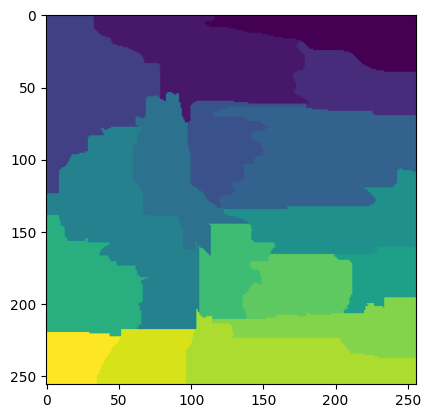

In [13]:
plt.clf()
plt.imshow(out["seg_maps"][0].cpu().numpy())

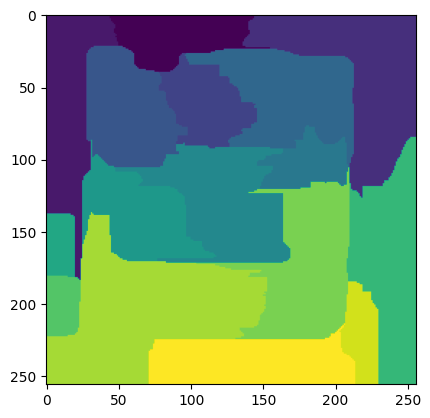

In [14]:
plt.clf()
plt.imshow(out["seg_maps"][1].cpu().numpy())